In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns

%matplotlib inline

In [2]:
df_microbial = pd.read_pickle('./pkls/has_microbial.pkl')

<h5>Clean and flatten data containing microbial test results</h5>

In [4]:
df_microbial_results = pd.DataFrame()
not_included = 0
for index, row in df_microbial.iterrows():
    
    #Check if entry a dict or list containing the one dict, because both formats will appear
    is_dict = type(row['coa_data']['microbial_test']) is dict
    #print(is_dict)
    
    #pull out test results for this test type
    microbial_results = row['coa_data']['microbial_test']['results'] if is_dict else row['coa_data']['microbial_test'][0]['results']
    if (type(microbial_results) is not dict):
        not_included += 1
        continue
    #create new df from retrieved dictionary so that it can be merged with data from other rows,
    #then keep only the row "amount"
    temp_df = pd.DataFrame.from_dict(microbial_results)
    temp_df = temp_df[temp_df.index == 'amount'].reset_index()
    df_microbial_results = df_microbial_results.append(temp_df, ignore_index = True)


print(df_microbial_results.head())

/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


  Aspergillus flavus Aspergillus fumigatus Aspergillus niger  \
0                  0                     0                 0   
1                  0                     0                 0   
2                  0                     0                 0   
3                  0                     0                 0   
4                  0                     0                 0   

  Aspergillus terreus Escherichia coli Salmonella bongori Salmonella enterica  \
0                   0                0                  0                   0   
1                   0                0                  0                   0   
2                   0                0                  0                   0   
3                   0                0                  0                   0   
4                   0                0                  0                   0   

  Salmonella spp.   index  
0               0  amount  
1               0  amount  
2               0  amount  
3               

In [20]:
print(not_included)

3


<h5>Let's sniff and clean the data</h5>

In [7]:
df_microbial_results.describe()

,Aspergillus flavus,Aspergillus fumigatus,Aspergillus niger,Aspergillus terreus,Escherichia coli,Salmonella bongori,Salmonella enterica,Salmonella spp.,index
count,7066,7066,7066,7066,7624,7624,7624,7590,7624
unique,3,3,3,3,4,3,3,1,1
top,0,0,0,0,0,0,0,0,amount
freq,7011,7031,7046,7051,7620,7621,7622,7590,7624


In [9]:
for column in df_microbial_results.columns:
    print(column, df_microbial_results[column].unique())

Aspergillus flavus [0 nan 'Detected' '0']
Aspergillus fumigatus [0 nan 'Detected' '1']
Aspergillus niger [0 nan 'Detected' '0']
Aspergillus terreus [0 nan 'Detected' '0']
Escherichia coli [0 '1' 'Detected' '0']
Salmonella bongori [0 '1' '0']
Salmonella enterica [0 '1' '0']
Salmonella spp. [0 nan]
index ['amount']


In [12]:
for column in df_microbial_results.columns:
    df_microbial_results[column].replace(['Detected', '1'], 1, inplace=True)
    df_microbial_results[column].replace('0', 0, inplace=True)

In [13]:
for column in df_microbial_results.columns:
    print(column, df_microbial_results[column].unique())

Aspergillus flavus [  0.  nan   1.]
Aspergillus fumigatus [  0.  nan   1.]
Aspergillus niger [  0.  nan   1.]
Aspergillus terreus [  0.  nan   1.]
Escherichia coli [0 1]
Salmonella bongori [0 1]
Salmonella enterica [0 1]
Salmonella spp. [  0.  nan]
index ['amount']


In [14]:
df_microbial_results.dtypes

Aspergillus flavus       float64
Aspergillus fumigatus    float64
Aspergillus niger        float64
Aspergillus terreus      float64
Escherichia coli           int64
Salmonella bongori         int64
Salmonella enterica        int64
Salmonella spp.          float64
index                     object
dtype: object

In [15]:
df_microbial_results = df_microbial_results.drop('index', axis=1)

In [16]:
df_microbial_results.describe()

,Aspergillus flavus,Aspergillus fumigatus,Aspergillus niger,Aspergillus terreus,Escherichia coli,Salmonella bongori,Salmonella enterica,Salmonella spp.
count,7066.000000,7066.000000,7066.000000,7066.000000,7624.000000,7624.000000,7624.000000,7590.0
mean,0.007642,0.004953,0.002689,0.001981,0.000393,0.000262,0.000131,0.0
std,0.087091,0.070210,0.051789,0.044471,0.019834,0.016196,0.011453,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [17]:
df_microbial_results.to_pickle('./pkls/cleaned_microbial_results.pkl')

In [19]:
df_microbial_results.drop_duplicates().describe()

,Aspergillus flavus,Aspergillus fumigatus,Aspergillus niger,Aspergillus terreus,Escherichia coli,Salmonella bongori,Salmonella enterica,Salmonella spp.
count,16.000000,16.000,16.000000,16.000000,18.000000,18.000000,18.000000,13.0
mean,0.250000,0.375,0.312500,0.250000,0.166667,0.111111,0.055556,0.0
std,0.447214,0.500,0.478714,0.447214,0.383482,0.323381,0.235702,0.0
min,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.250000,1.000,1.000000,0.250000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [21]:
correlations = df_microbial_results.corr()

In [22]:
print(correlations)

                       Aspergillus flavus  Aspergillus fumigatus  \
Aspergillus flavus               1.000000               0.063252   
Aspergillus fumigatus            0.063252               1.000000   
Aspergillus niger                0.340642               0.190972   
Aspergillus terreus              0.069181               0.178187   
Escherichia coli                -0.001809              -0.001454   
Salmonella bongori              -0.001477              -0.001187   
Salmonella enterica             -0.001044              -0.000839   
Salmonella spp.                       NaN                    NaN   

                       Aspergillus niger  Aspergillus terreus  \
Aspergillus flavus              0.340642             0.069181   
Aspergillus fumigatus           0.190972             0.178187   
Aspergillus niger               1.000000             0.243516   
Aspergillus terreus             0.243516             1.000000   
Escherichia coli               -0.001070            -0.000918 

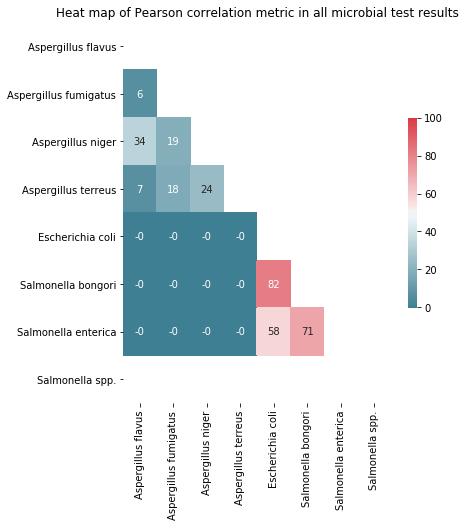

In [23]:
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(6, 7))
plt.title('Heat map of Pearson correlation metric in all microbial test results')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr_heat = sns.heatmap(correlations * 100, annot=True, fmt='.0f', mask=mask, cmap=cmap, cbar_kws={"shrink": .5})


<h4>Now looking at correlations after dropping duplicates</h4>
<p>After dropping duplicates the number of data points decreases from >7000 to < 20 </p>

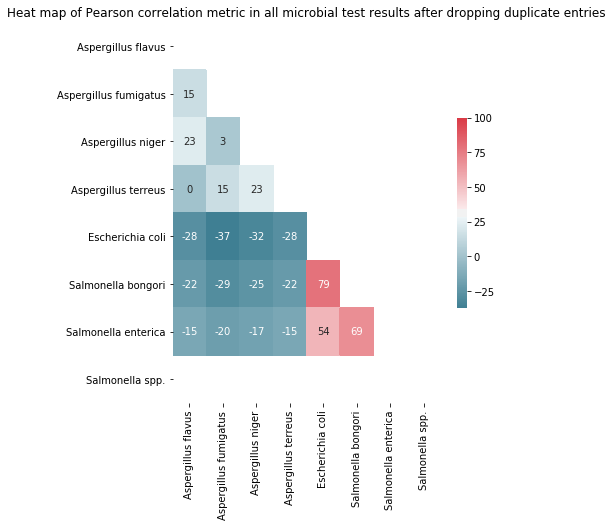

In [26]:
newCorrelations = df_microbial_results.drop_duplicates().corr()

mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(6, 7))
plt.title('Heat map of Pearson correlation metric in all microbial test results after dropping duplicate entries')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr_heat = sns.heatmap(newCorrelations * 100, annot=True, fmt='.0f', mask=mask, cmap=cmap, cbar_kws={"shrink": .5})

/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


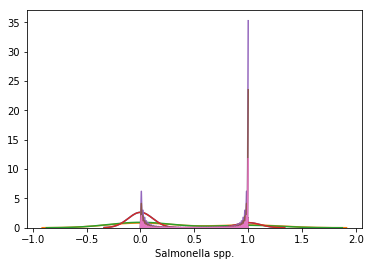

In [24]:
for column in df_microbial_results.columns:
    sns.distplot(df_microbial_results.drop_duplicates()[column], hist=False, rug=True);

/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


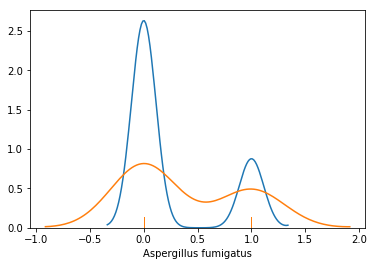

In [31]:
sns.distplot(df_microbial_results.drop_duplicates()['Aspergillus terreus'], hist=False, rug=True);
sns.distplot(df_microbial_results.drop_duplicates()['Aspergillus fumigatus'], hist=False, rug=True);

Text(0.5,0.98,'Linear regression plot of Escherichia coli vs Salmonella bongori')

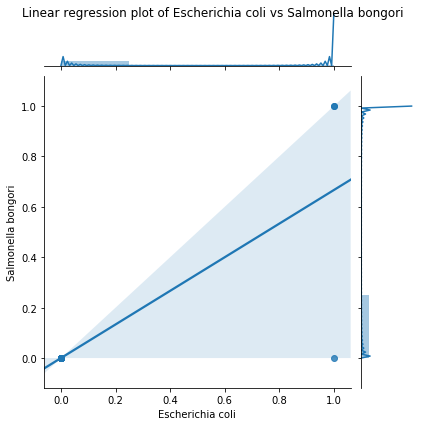

In [29]:
fig = sns.jointplot("Escherichia coli", "Salmonella bongori", data=df_microbial_results.drop_duplicates(), kind="reg",)
                #xlim=(0, 0.1), ylim=(0, 0.5))
fig_size = [7,6]
plt.xlabel('Escherichia coli')
plt.ylabel('Salmonella bongori')
plt.suptitle('Linear regression plot of Escherichia coli vs Salmonella bongori')